<a href="https://colab.research.google.com/github/KabeloPhiri/Ernst-and-Young-2022-Better-Working-World-Data-Challenge/blob/main/EY_Data_Challenge_Level_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contextily
!pip install zarr
!pip install fsspec
!pip install pystac
!pip install requests
!pip install aiohttp
!pip install sci-analysis
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 153 kB 27.1 MB/s 
     |████████████████████████████████| 6.2 MB 40.6 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=fc679de65c0cd088b36340234f941d1d400ebbc879b7f83631d00e69948bd1c2
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 26.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 29.8 MB/s 
Looking in indexes: htt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from itertools import cycle
import contextily as cx
import warnings
import zipfile
import os
import pystac
import fsspec
import xarray as xr
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import itertools
import os
import zipfile
from itertools import cycle
from imblearn.over_sampling import RandomOverSampler

data_path = '/content/drive/MyDrive/EY Data/'
output_path = '/content/drive/MyDrive/EY Data/'

# Functions

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)
    
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)
def plot_species(fig, ax, frog_data, region_name, colourmap=None):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)
    # Colour cycle to ensure colors match in both plots
    if colourmap is None:
        colourmap = {species:colour['color'] for species, colour in zip(frog_data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}
    for i in range(len(bar_data)):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(colourmap[species_name])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=colourmap[species_name]
        )
    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
def plot_barchart(bar_data, ax, colourmap=None, bar_params={}):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    if colourmap is None:
        prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
        colourmap = {spec:col['color'] for spec, col in zip(bar_data.index, prop_cycle)}
    for i in range(len(bar_data)):
        var_name = bar_data.index[i]
        barchart[i].set_color(colourmap[var_name])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()
    
    
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs
    
    
# Plotting functions
def plotDot(point, folium_map, species_colours):
    folium.CircleMarker(
        location=[point.decimalLatitude, point.decimalLongitude],
        radius=10,
        stroke=False,
        weight=5,
        fill=True,
        fillOpacity=1.0,
        opacity=1.0,
        color=species_colours[point.species]
    ).add_to(folium_map)
    

def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

In [ ]:
columns = [
    'gbifID','eventDate','country','continent','stateProvince',
    'decimalLatitude','decimalLongitude','species', 'coordinateUncertaintyInMeters'
]

country_names = {
    'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
    'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
    'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
    'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
}

continent_names = {
    'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
    'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
    'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
    'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
}
    
data = (
    pd.read_csv(data_path+'/training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
    .assign(
        country =  lambda x: x.countryCode.map(country_names),
        continent =  lambda x: x.countryCode.map(continent_names),
        species = lambda x: x.species.str.title()
    )    
    # Rename ranoidea australis to cyclorana australis
    .assign(species = lambda x: np.where(x.species == 'Ranoidea Australis', 'Cyclorana Australis', x.species))
    [columns]
)


np.sum(data.isna())/len(data)*100

gbifID                           0.000000
eventDate                        4.522914
country                          0.000000
continent                        0.000000
stateProvince                    0.357086
decimalLatitude                  0.000000
decimalLongitude                 0.000000
species                          0.000000
coordinateUncertaintyInMeters    8.986485
dtype: float64

# Data Visualization 

#         Spatial distribution

In [ ]:
species_colourmap = {species:colour['color'] for species, colour in zip(data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}


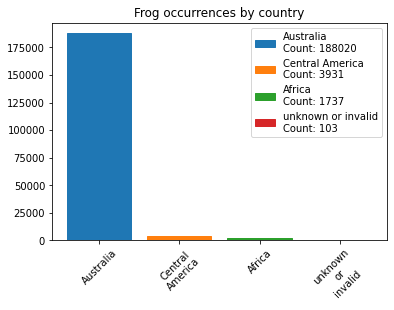

In [ ]:
country_bar_data = data.continent.value_counts()
fig, ax = plt.subplots()
plot_barchart(country_bar_data, ax)
ax.set_title('Frog occurrences by country')
plt.show()

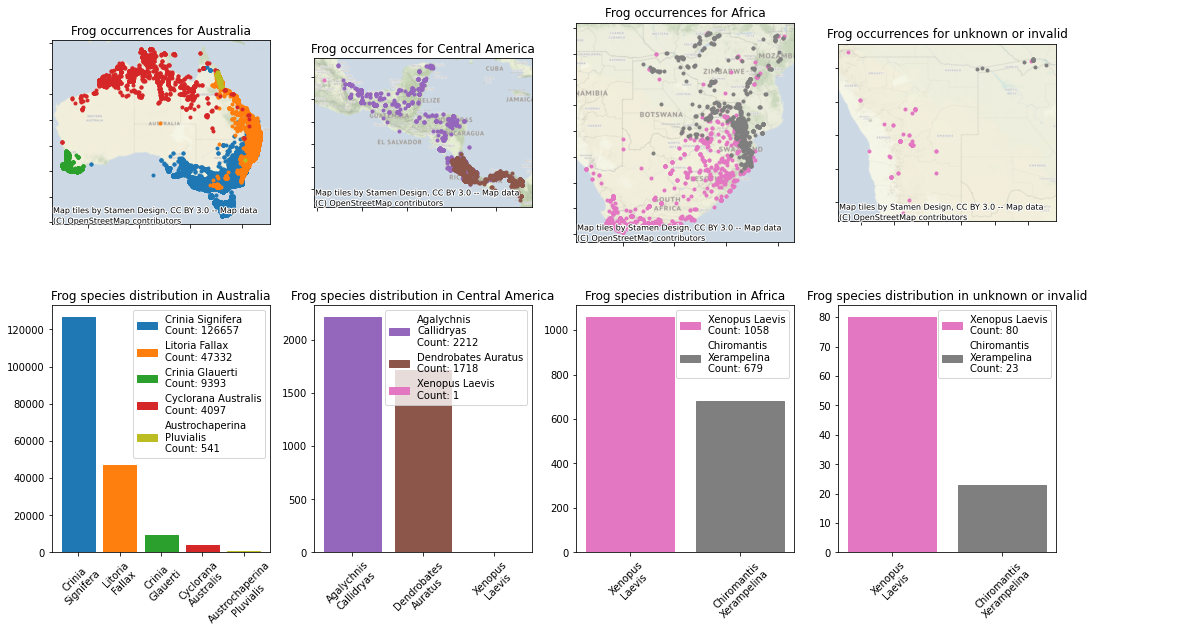

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10))
for i, cnt in enumerate(data.continent.unique()):
    filt = data.continent == cnt
    plot_species(fig, ax[:, i], data[filt], cnt, colourmap=species_colourmap)

In [ ]:
# Take only Australia
data = data[data.country.str.contains('Australia')]

In [ ]:
#create a map
frog_map = folium.Map(prefer_canvas=True)

# plot 1000 points from each country
(
     data[data.country == 'Australia'].sample(1000, random_state=420)
).apply(
    plotDot, axis = 1, args=(frog_map, species_colourmap)
)

#Set the zoom to the maximum possible
frog_map.fit_bounds(frog_map.get_bounds())
#Lat lon on click
frog_map.add_child(folium.LatLngPopup())
#Save the map to an HTML file
frog_map.save(output_path+'frog_map_training.html')
frog_map

# Temporal Distribution

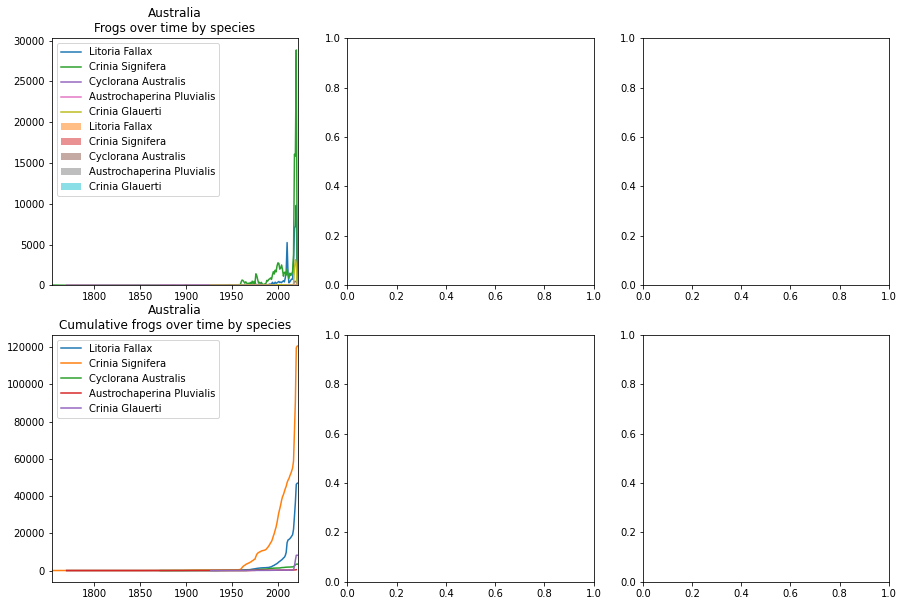

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, cnt in enumerate(data.country.unique()):
    country_data = data[data.country == cnt]    
    for species in country_data.species.unique():
        plot_data = country_data[lambda x: x.species == species]
        line_data = (
            plot_data
            [['eventDate']]
            .dropna()
            .assign(
                year = lambda x: x.eventDate.dt.year,
                n = 1
            )
            .groupby('year')
            .sum()
            .reset_index()
            .sort_values('year')
            .assign(ncum=lambda x: x.n.cumsum())
        )
        ax[1, i].plot(line_data.year, line_data.ncum, label=species)
        ax[0, i].plot(line_data.year, line_data.n, label=species)
        ax[0, i].hist(plot_data.eventDate.dt.year, alpha=0.5, label=species, density=True, bins=list(range(1900, 2025, 10)))
#xlim = (1900, 2025)
xlim = (country_data.eventDate.dt.year.min(), country_data.eventDate.dt.year.max()) 
ax[1, i].legend(loc='upper left')
ax[1, i].set_xlim(xlim)
ax[1, i].set_title(f"{cnt}\nCumulative frogs over time by species")
ax[0, i].legend(loc='upper left')
ax[0, i].set_xlim(xlim)
ax[0, i].set_title(f"{cnt}\nFrogs over time by species")

plt.savefig('Temporal Plot.pdf')



# DATA ANALYSIS


# Dealing WIth Data 

In this section of the data analysis we will be taking samples of the entire Australlua but breaking them into smaller 'chunks'


# Pseudo absence technique (Without Chunks)


In [ ]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (148.15, -32.25)  # Lower-left corner
max_lon, max_lat = (154.15, -25.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
40,2456512415,2016-04-17 11:12:00,Australia,Australia,Queensland,-27.476426,152.977687,Litoria Fallax
53,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax
149,1253333795,2015-09-24 00:00:00,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera
287,1253333801,2015-09-24 00:00:00,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera
...,...,...,...,...,...,...,...,...
193456,2806364201,2016-08-19 00:00:00,Australia,Australia,New South Wales,-28.545595,153.511738,Crinia Signifera
193458,1452510604,2015-10-23 00:00:00,Australia,Australia,New South Wales,-31.535671,152.714970,Crinia Signifera
193481,3108888622,2019-06-27 00:00:00,Australia,Australia,New South Wales,-30.194400,153.011000,Crinia Signifera
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax


In [ ]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1
40,2456512415,2016-04-17 11:12:00,Australia,Australia,Queensland,-27.476426,152.977687,Litoria Fallax,1
53,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax,1
149,1253333795,2015-09-24 00:00:00,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera,0
287,1253333801,2015-09-24 00:00:00,Australia,Australia,New South Wales,-30.280630,150.166360,Crinia Signifera,0
...,...,...,...,...,...,...,...,...,...
193456,2806364201,2016-08-19 00:00:00,Australia,Australia,New South Wales,-28.545595,153.511738,Crinia Signifera,0
193458,1452510604,2015-10-23 00:00:00,Australia,Australia,New South Wales,-31.535671,152.714970,Crinia Signifera,0
193481,3108888622,2019-06-27 00:00:00,Australia,Australia,New South Wales,-30.194400,153.011000,Crinia Signifera,0
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax,1


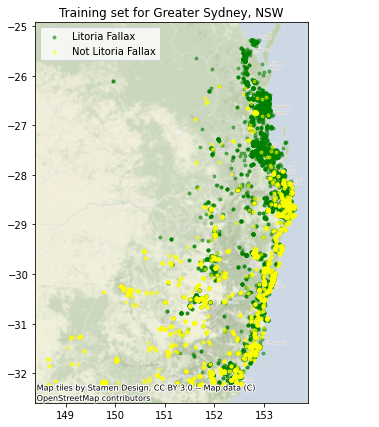

In [ ]:
fig, ax = plt.subplots(figsize = (7, 7))
frog_data = all_frog_data
filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")
plt.show()

# Pseudo absence technique (Data in Chunks)

In [ ]:
data_path = '/content/drive/MyDrive/EY Data/'
min_lat = 150
max_lat = 160
min_lon = -40
max_lon = -33
frog_vec = pd.DataFrame()
location_grid = list()
for i in range(min_lat,max_lat,1):
    for a in range(min_lon,max_lon,1):
        min_lon,min_lat = (i,a)
        max_lon,max_lat = (i+1,a+1)
        bbox = (min_lon, min_lat, max_lon, max_lat)
        all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
        if not all_frog_data.empty:
            location_grid.append(all_frog_data)
            


KeyboardInterrupt: ignored

In [ ]:
location_grid 


In [ ]:

target_species = 'Litoria Fallax'

all_frog_data = (
    location_grid[3]
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data




In [ ]:
fig, ax = plt.subplots(figsize = (7, 7))
frog_data = all_frog_data
filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")
plt.show()

# Class balancing

# Class balancing (Down Sampling Method)

In [ ]:
#data_path = 'C:/Users/kabel/OneDrive/Documents/The Wellness System/EY Data Challenge/'


In [ ]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'

min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)
#data_path = 'C:/Users/kabel/OneDrive/Documents/The Wellness System/EY Data Challenge/'
# Load in data
all_frog_data = get_frogs(data_path+'training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
935,3108894201,2017-11-12,Australia,Australia,New South Wales,-33.699881,151.043367,Litoria Fallax
941,3108882429,2019-09-19,Australia,Australia,New South Wales,-33.955790,150.976815,Crinia Signifera
944,3108953063,2019-11-03,Australia,Australia,New South Wales,-33.755278,150.623221,Litoria Fallax
945,3108952573,2019-11-04,Australia,Australia,New South Wales,-33.755291,150.623651,Litoria Fallax
980,1452200212,2015-06-16,Australia,Australia,New South Wales,-33.951844,150.870430,Litoria Fallax
...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera


In [ ]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
935,3108894201,2017-11-12,Australia,Australia,New South Wales,-33.699881,151.043367,Litoria Fallax,1
941,3108882429,2019-09-19,Australia,Australia,New South Wales,-33.955790,150.976815,Crinia Signifera,0
944,3108953063,2019-11-03,Australia,Australia,New South Wales,-33.755278,150.623221,Litoria Fallax,1
945,3108952573,2019-11-04,Australia,Australia,New South Wales,-33.755291,150.623651,Litoria Fallax,1
980,1452200212,2015-06-16,Australia,Australia,New South Wales,-33.951844,150.870430,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera,0
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax,1
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax,1
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera,0


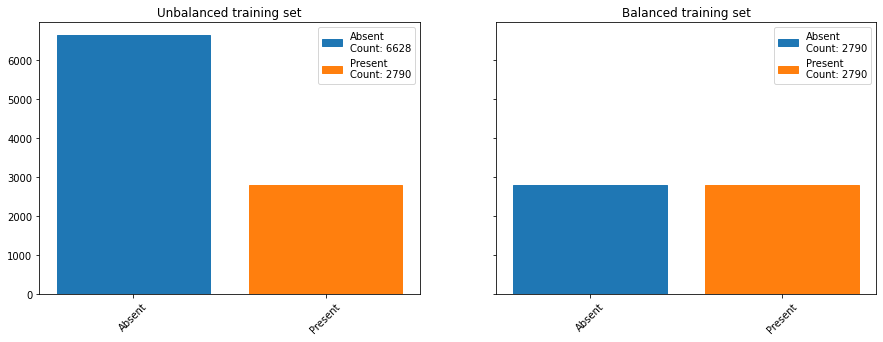

In [ ]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')
plt.show()

# Class balancing (Duplicate undersampled samples)

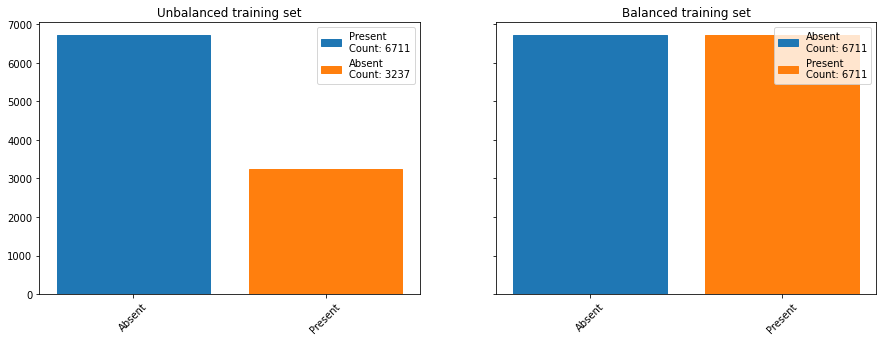

In [ ]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420, replace = True
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')
plt.show()

In [ ]:
#Applying SMOTE on the training data
import imblearn
smote = imblearn.over_sampling.SMOTE(sampling_strategy=1.0, k_neighbors=2)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Feature Engineering

This section will outline all the feature engineering tasks done on the samples. The first feature engineering step will be done on the EventDate

Using the pandas ‘to_datetime’ function the ‘eventDate' is changed from a string data type to a  datetime64[ns] data type. This allows us to split the eventDate feature into its subsequent features being: ‘eventDay’, ’eventMonth’, ‘eventYear’, ‘eventDayWeek’ , ‘eventDayHour’, ’eventDayMinute’


In [ ]:
data['eventDate'] = pd.to_datetime(data['eventDate'], 
                                   format = '%Y-%m-%dT%H:%M:%SZ',
                                   errors = 'coerce')

data['eventYear'] = data['eventDate'].dt.year
data['eventMonth'] = data['eventDate'].dt.month
data['eventDay'] = data['eventDate'].dt.day
data['eventWeek'] = data['eventDate'].dt.week
data['eventDayofWeek'] = data['eventDate'].dt.dayofweek
data['eventDayHour'] = data['eventDate'].dt.hour
data['eventDayMinute'] = data['eventDate'].dt.minute


Imputation to deal with missing values of transformed 'eventDate' feature using fillna()

In [ ]:
data['eventYear'] = data['eventYear'].fillna(data['eventYear'].mean())
data['eventMonth'] = data['eventMonth'].fillna(data['eventMonth'].mean())
data['eventDay'] = data['eventDay'].fillna(data['eventDay'].mean())
data['eventWeek'] = data['eventWeek'].fillna(data['eventWeek'].mean())
data['eventDayofWeek'] = data['eventDayofWeek'].fillna(data['eventDayofWeek'].mean())
data['eventDayHour'] = data['eventDayHour'].fillna(data['eventDayHour'].mean())
data['eventDayMinute'] = data['eventDayMinute'].fillna(data['eventDayMinute'].mean())


Imputation to deal with missing values in 'coordinateUncertaintyInMeters' using fillna()

In [ ]:
data['coordinateUncertaintyInMeters']  = data['coordinateUncertaintyInMeters'].fillna(data['coordinateUncertaintyInMeters'].mode()) 

# Predictor Variables


In [ ]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
#display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


Visualize Teraa climate data

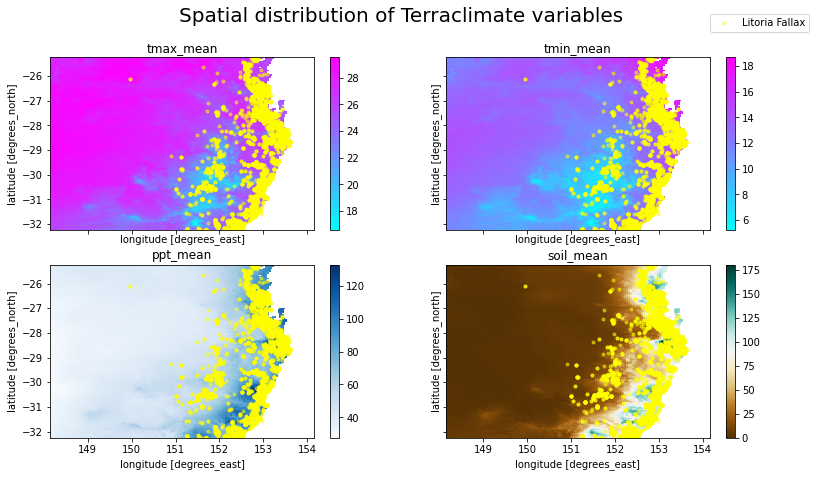

In [ ]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

# Feature Engineering (Dealing with missing values)

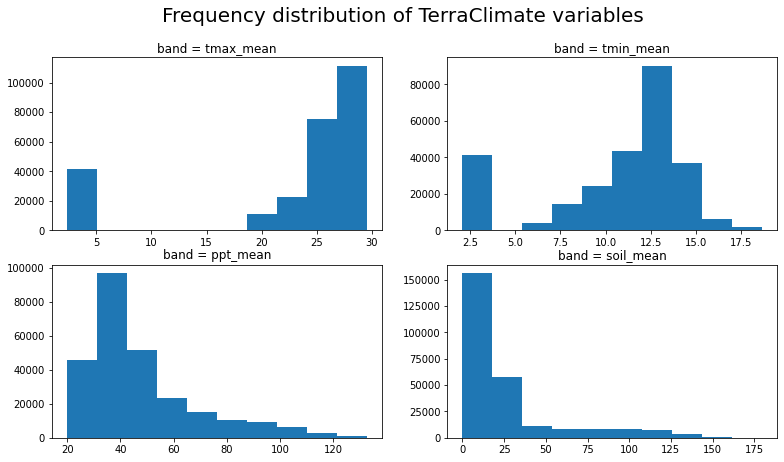

In [ ]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))
for i in range(len(bands)):
  weather_data[i] = weather_data[i].fillna(weather_data[i].mean())
  xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])
  fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

# Feauture Engineering ( Mean Normalization)

ValueError: ignored

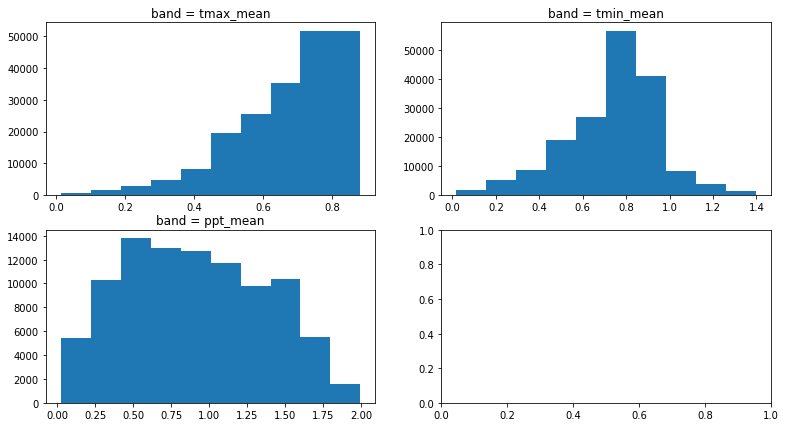

In [ ]:

#display(weather_data.band.values)
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values
i = 0
mean_normal = (weather_data[i]-weather_data[i].mean())/(weather_data[i].std())
weather_data[i] = np.sqrt(weather_data[i])
xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

i = 1
mean_normal = (weather_data[i]-weather_data[i].mean())/weather_data[i].std()
weather_data[i] = np.sqrt(mean_normal)
xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

i = 2
mean_normal = (weather_data[i]-weather_data[i].mean())/weather_data[i].std()
weather_data[i] = np.log(weather_data[i])
xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

i = 3
mean_normal = (weather_data[i]-weather_data[i].mean())/weather_data[i].std()
weather_data[i] = np.sqrt(mean_normal)
xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

Joining Predictors to the Response Variable

In [ ]:


model_data = join_frogs(frog_data, weather_data)
model_data.dropna(inplace=True)
model_data.reset_index(drop = True, inplace = True)
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,ppt_mean,soil_mean,tmax_mean,tmin_mean
0,3108878655,2018-05-13,Australia,Australia,New South Wales,-28.665345,153.448406,Crinia Signifera,0,0,4.789018,1.937235,4.996666,1.163324
1,3463696233,2018-05-19,Australia,Australia,New South Wales,-29.505489,152.824340,Crinia Signifera,0,1,4.252772,0.973654,5.095586,0.813092
2,3463497997,2019-04-18,Australia,Australia,New South Wales,-31.479253,152.868627,Crinia Signifera,0,2,4.634081,1.620126,4.939129,0.956792
3,3108939653,2018-09-05,Australia,Australia,New South Wales,-28.813150,153.262706,Crinia Signifera,0,5,4.466100,1.551466,5.103267,1.116555
4,3108918671,2019-04-27,Australia,Australia,New South Wales,-29.503927,153.221818,Crinia Signifera,0,6,4.451047,1.364695,5.002832,1.200665


In [ ]:
np.sum(model_data.isna())/len(model_data)*100

gbifID              0.0
eventDate           0.0
country             0.0
continent           0.0
stateProvince       0.0
decimalLatitude     0.0
decimalLongitude    0.0
species             0.0
occurrenceStatus    0.0
key                 0.0
ppt_mean            0.0
soil_mean           0.0
tmax_mean           0.0
tmin_mean           0.0
dtype: float64

# Model Building 

In [ ]:
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
)
y = model_data.occurrenceStatus.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)




scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training (Logistic Regression)

In [ ]:
full_model = LogisticRegression()
# Separate the predictor variables from the response

# Fit model
full_model.fit(X_train, y_train)

predictions = full_model.predict(X_test)



# Model training (XGBoost Classifier Grid Search)

In [ ]:
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

csv.fit(X_train,y_train)
csv.best_params_

{'max_depth': 2, 'min_child_weight': 3}

In [ ]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight':4}
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)
csv.fit(X_test,y_test)
csv.best_params_


{'max_delta_step': 0, 'subsample': 0.9}

In [ ]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}
fix_params['max_delta_step'] = 1
fix_params['subsample'] = 0.8

{'learning_rate': 0.05}

In [ ]:
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5) 
csv.fit(X_train, y_train)
#csv.grid_scores_
csv.best_params_

{'learning_rate': 0.15}

In [ ]:
fix_params['learning_rate'] = 0.15
params_final =  fix_params
print(params_final)

{'learning_rate': 0.15, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 4, 'max_delta_step': 1, 'subsample': 0.8}


In [ ]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

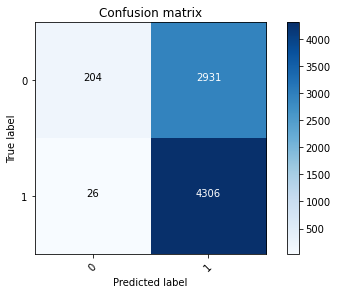

Precision =     0.595
Recall (TPR) =  0.994
Fallout (FPR) = 9.349e-01


In [ ]:
y_pred = xgb_final.predict(xgdmat_test)
thresh = 0.08
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = show_data(cm, print_res = 1);

# Model Training ( Naive Bayes)

In [ ]:
from sklearn.naive_bayes import GaussianNB

# instantiate the model
gnb = GaussianNB()
# fit the model
naive = gnb.fit(X_train, y_train)

In [ ]:
Naive_pred = gnb.predict(X_test)

Naive_pred

array([1, 1, 0, ..., 1, 0, 1])

# Model Training (Neural Network)

In [ ]:
# convert to numpy arrays
X = np.array(X_train)

# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X,
                    y_train,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                80        
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
200/200 [==============================] - 1s 3ms/step - loss: 0.6288 - accuracy: 0.6218 - val_loss: 0.5687 - val_accuracy: 0.6867
Epoch 2/80
200/200 [==============================] - 0s 2ms/step - loss: 0.5647 - accuracy: 0.6720 - val_loss: 0.5302 - val_accuracy: 0.6988
Epoch 3/80
200/200 [================

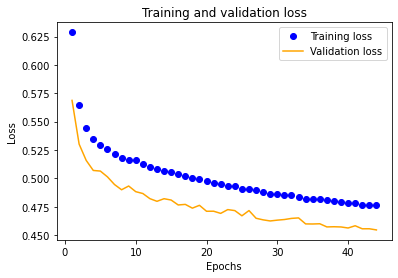

In [ ]:

history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

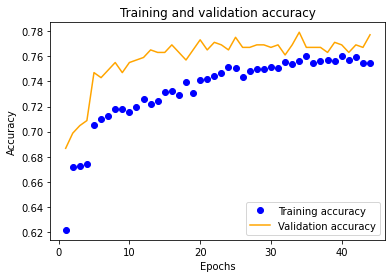

0.7791164517402649

In [ ]:

# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')

# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# see how these are numbers between 0 and 1? 
NN_model = model.predict(X) # prob of successes (survival)
np.round(model.predict(X),0) # 1 and 0 (survival or not)


# so we need to round to a whole number (0 or 1),
# or the confusion matrix won't work!
NN_preds = np.round(model.predict(X_test),0)

# confusion matrix
print(confusion_matrix(y_test, NN_preds)) # order matters! (actual, predicted)

## array([[490,  59],   ([[TN, FP],

##       [105, 235]])     [Fn, TP]])

print(classification_report(y_test, NN_preds))

[[2433  702]
 [1316 3016]]
              precision    recall  f1-score   support

           0       0.65      0.78      0.71      3135
           1       0.81      0.70      0.75      4332

    accuracy                           0.73      7467
   macro avg       0.73      0.74      0.73      7467
weighted avg       0.74      0.73      0.73      7467



# Model Training (Random Forests)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
RF_preds = forest_model.predict(X_test)

from sklearn.metrics import accuracy_score

print(mean_absolute_error(y_test, RF_preds))
accuracy_score(y_test, RF_preds)
confusion_matrix(y_test, RF_preds)
# View the classification report for test data and predictions
print(classification_report(y_test, RF_preds))

0.20342841837417971
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      3135
           1       0.87      0.76      0.81      4332

    accuracy                           0.80      7467
   macro avg       0.80      0.80      0.79      7467
weighted avg       0.81      0.80      0.80      7467



# Model Training (SVM)




In [ ]:
from sklearn.svm import SVC
from sklearn import metrics
svc=SVC() #Default hyperparameters
SVM_model = svc.fit(X_train,y_train)
SVM_pred=svc.predict(X_test)



# Model Evaluation

In [ ]:
print("Logistic Regression Results")
print(classification_report(y_test, predictions))

print()

print("XGBoost CLassifier Results")
print(classification_report(y_test, y_pred))

print()

print("Naive Bayes Results")
print(classification_report(y_test, Naive_pred))

print()

print("Neural Network  Results")
print(classification_report(y_test, NN_preds))

print() 

print(" Random Forrrests Classifier results")
print(classification_report(y_test, RF_preds))

print()

print(" SVM Classifier results")
print(classification_report(y_test, SVM_pred))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      3135
           1       0.71      0.74      0.73      4332

    accuracy                           0.68      7467
   macro avg       0.67      0.66      0.66      7467
weighted avg       0.67      0.68      0.67      7467


XGBoost CLassifier Results
              precision    recall  f1-score   support

           0       0.89      0.07      0.12      3135
           1       0.59      0.99      0.74      4332

    accuracy                           0.60      7467
   macro avg       0.74      0.53      0.43      7467
weighted avg       0.72      0.60      0.48      7467


Naive Bayes Results
              precision    recall  f1-score   support

           0       0.59      0.65      0.62      3135
           1       0.73      0.68      0.70      4332

    accuracy                           0.67      7467
   macro avg       0.66      0.67      0.66      74

# Out sample model evaluation 

In [ ]:
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key'], 1)
)
y = model_data.occurrenceStatus.astype(int)


Logistic regression

In [ ]:

cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.73
Accuracy: 0.67


XGBoost Classifier Grid Search

In [ ]:

cv_model = csv

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.83
Accuracy: 0.82


Naive Bayes

In [ ]:

cv_model = gnb

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.8
Accuracy: 0.73


Neaural Network

In [ ]:
cv_model = model

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")

Fold 1 of 10
69/69 [==============================] - 0s 2ms/step - loss: 0.5366 - accuracy: 0.7374


ValueError: ignored

Forest Model

In [ ]:
cv_model = forest_model

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.85
Accuracy: 0.79


SVM

In [ ]:
cv_model = svc

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")

Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.82
Accuracy: 0.76


# Predict Entire Region

In [ ]:
full_model = SVC(gamma='auto', probability=True)
full_model = full_model.fit(X,y)

In [ ]:
# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, full_model)

# Submission

In [ ]:
# Load in test coordinates
test_file = pd.read_csv('/content/drive/MyDrive/EY Data/challenge_1_submission_template.csv')

In [ ]:
# Read in test regions
test_1_regions = []
with open('/content/drive/MyDrive/EY Data/challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [ ]:
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Loading data
Calculating mean
Calculating min
Calculating max


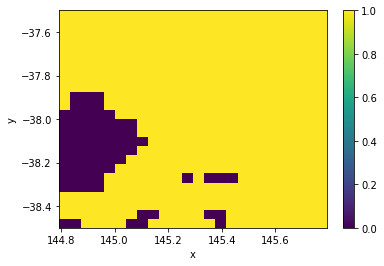

Loading data
Calculating mean
Calculating min
Calculating max


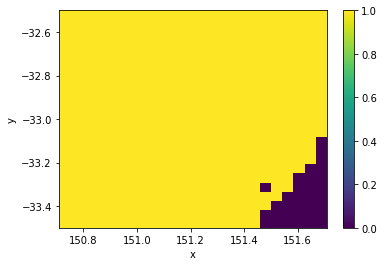

Loading data
Calculating mean
Calculating min
Calculating max


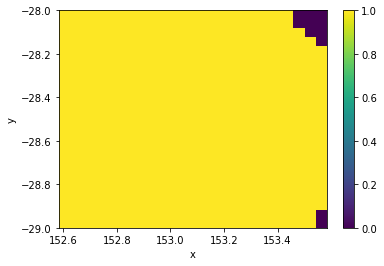

Loading data
Calculating mean
Calculating min
Calculating max


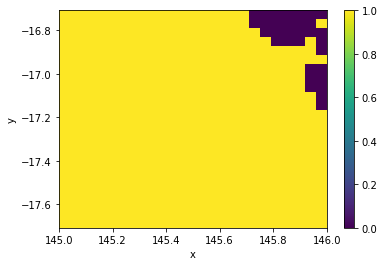

Loading data
Calculating mean
Calculating min
Calculating max


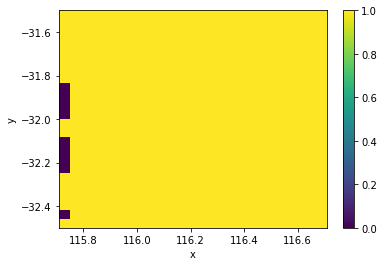

In [ ]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()

In [ ]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)

In [ ]:
display(submission)

# Save to output folder
submission.to_csv('challenge_1_submission_benchmark.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,1
1,1,-37.770833,144.979167,1
2,2,-37.979167,145.354167,1
3,3,-37.604167,145.020833,1
4,4,-38.479167,145.645833,1
...,...,...,...,...
4046,4046,-31.895833,116.145833,1
4047,4047,-32.395833,115.770833,1
4048,4048,-32.145833,115.854167,1
4049,4049,-31.812500,116.229167,1
